<a href="https://colab.research.google.com/github/oliviasteeed/Computer-Vision-Project/blob/main/computervision_actual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Project: Text detection from images
This project identifies and types out written words from images. It uses object detection to find where text is in an image, and then classification to identify the word.

v2

### Set up ultralytics and install dependencies

In [ ]:
!pip3 install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
Setup complete ✅ (4 CPUs, 8.0 GB RAM, 311.6/894.1 GB disk)


In [ ]:
import cv2
import matplotlib.pyplot as plt
import random as random
import os
import glob
%matplotlib inline
from PIL import Image
from ultralytics import YOLO

# 1. Text Detection

Detecting where text is in an image, and cropping images with text to bounding boxes

### Data Preprocessing

Datasets: three text detection datasets of images/screenshots with text enclosed in bounding boxes. I was going to try object detection for just handwriting, but found more data for typed text, so this model is intended to identify both with a bias for typed text. Because of this, the use case could also be for translation of typed text.

https://universe.roboflow.com/yolo-2uwb2/text-detection-jqlql

https://universe.roboflow.com/yolov5-train/yolo-find-text

https://universe.roboflow.com/akshithak-0pa4q/text-detection-qj5wx

In [ ]:
image_dir = '/Users/oliviasteed/Desktop/Text Dataset/images'
label_dir = '/Users/oliviasteed/Desktop/Text Dataset/labels'

dir = '/Users/oliviasteed/Desktop/Text Dataset'

In [ ]:
# write yaml file - did it this way so I could specify directory

with open('/Users/oliviasteed/Desktop/Text Dataset/config.yaml', 'w') as file:
    file.write('''\
path: /Users/oliviasteed/Desktop/Text Dataset
train: /Users/oliviasteed/Desktop/Text Dataset/images/train
test: /Users/oliviasteed/Desktop/Text Dataset/images/test
val: /Users/oliviasteed/Desktop/Text Dataset/images/val

# Classes
nc: 1

# Class names
names: ['Text']
''')

Draw a label bounding box to check accuracy

In [ ]:
# showing label - to check if it is labeled right (it is)
%matplotlib inline
from PIL import Image

def draw_yolo_bbox(image_path, label_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # Read label file
    with open(label_path, 'r') as file:
        bboxes = file.readlines()

    # Draw each bbox
    for bbox in bboxes:
        class_id, x_center, y_center, bbox_width, bbox_height = [float(x) for x in bbox.split()]

        # Convert YOLO bbox format to rectangle coordinates
        x1 = int((x_center - bbox_width / 2) * width)
        y1 = int((y_center - bbox_height / 2) * height)
        x2 = int((x_center + bbox_width / 2) * width)
        y2 = int((y_center + bbox_height / 2) * height)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Put label (class_id) near the bbox
        # label = class_labels[int(class_id)]
        label = "text"
        cv2.putText(image, label, (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    # Display image
    plt.imshow(image)
    # Image.open(image)
    plt.axis('off')
    plt.savefig('test.jpg')
    return

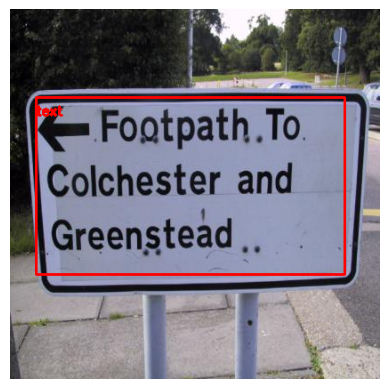

In [ ]:
draw_yolo_bbox("/Users/oliviasteed/Desktop/Text Dataset/images/train/100_jpg.rf.072e86458094f004ab381eb018f48ea0.jpg", "/Users/oliviasteed/Desktop/Text Dataset/labels/train/100_jpg.rf.072e86458094f004ab381eb018f48ea0.txt")

Check if there is unlabeled data

In [ ]:
#The lists of all the images and labels for train and validation set:
train_images=glob.glob(os.path.join(image_dir, "train",'*.jpg'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images=glob.glob(os.path.join(image_dir, "val",'*.jpg'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
#print(image_files_val)

In [ ]:
print(len(image_files_val), "  =  ", len(label_files_val))

243   =   243


In [ ]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): set()
Training Extra labels (without corresponding images): set()
Validation Extra images (without corresponding labels): set()
Validation Extra labels (without corresponding images): set()


No unlabeled data, so we can move on to model training.

### Transfer Learning for Object Detection

In [ ]:
# from ultralytics import YOLO

# make new model to train and load in weights from existing YOLO detection model
model = YOLO("yolov8n.yaml").load("yolov8n.pt")

# train model with text object detection data
results = model.train(data="/Users/oliviasteed/Desktop/Text Dataset/config.yaml", epochs=8, patience=5, batch=8, lr0=0.0005)

Transferred 355/355 items from pretrained weights
New https://pypi.org/project/ultralytics/8.3.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/oliviasteed/Desktop/Text Dataset/config.yaml, epochs=8, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=yolov8n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnosti

train: Scanning /Users/oliviasteed/Desktop/Text Dataset/labels/train.cache... 84
val: Scanning /Users/oliviasteed/Desktop/Text Dataset/labels/val.cache... 247 im


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8         0G      1.301      1.651      1.202          2        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652       0.77      0.782      0.825      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8         0G      1.202      1.177      1.148          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.901      0.839      0.907       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8         0G      1.185      1.087      1.152          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.918      0.859      0.941      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8         0G      1.149     0.9795      1.136          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.919      0.902      0.955       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8         0G      1.098     0.8674      1.103          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.959      0.894      0.969      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8         0G      1.055     0.8059      1.094          3        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.952      0.907      0.971      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8         0G      1.046     0.7768      1.077         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652       0.96      0.923      0.973      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8         0G      1.005     0.7216      1.068         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.949       0.95      0.981      0.717



8 epochs completed in 1.702 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        247        652      0.949      0.949      0.981      0.717
Speed: 5.1ms preprocess, 215.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train3


### Validation
I want to minimize errors with bounding boxes so will use IoU and Precision, plus mAP for an overview of model performance.

In [ ]:
metrics = model.val() # general validation

metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/oliviasteed/Desktop/Text Dataset/labels/val.cache... 247 im
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        247        652      0.949      0.949      0.981      0.717
Speed: 5.6ms preprocess, 286.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train32


0.9492219119233806

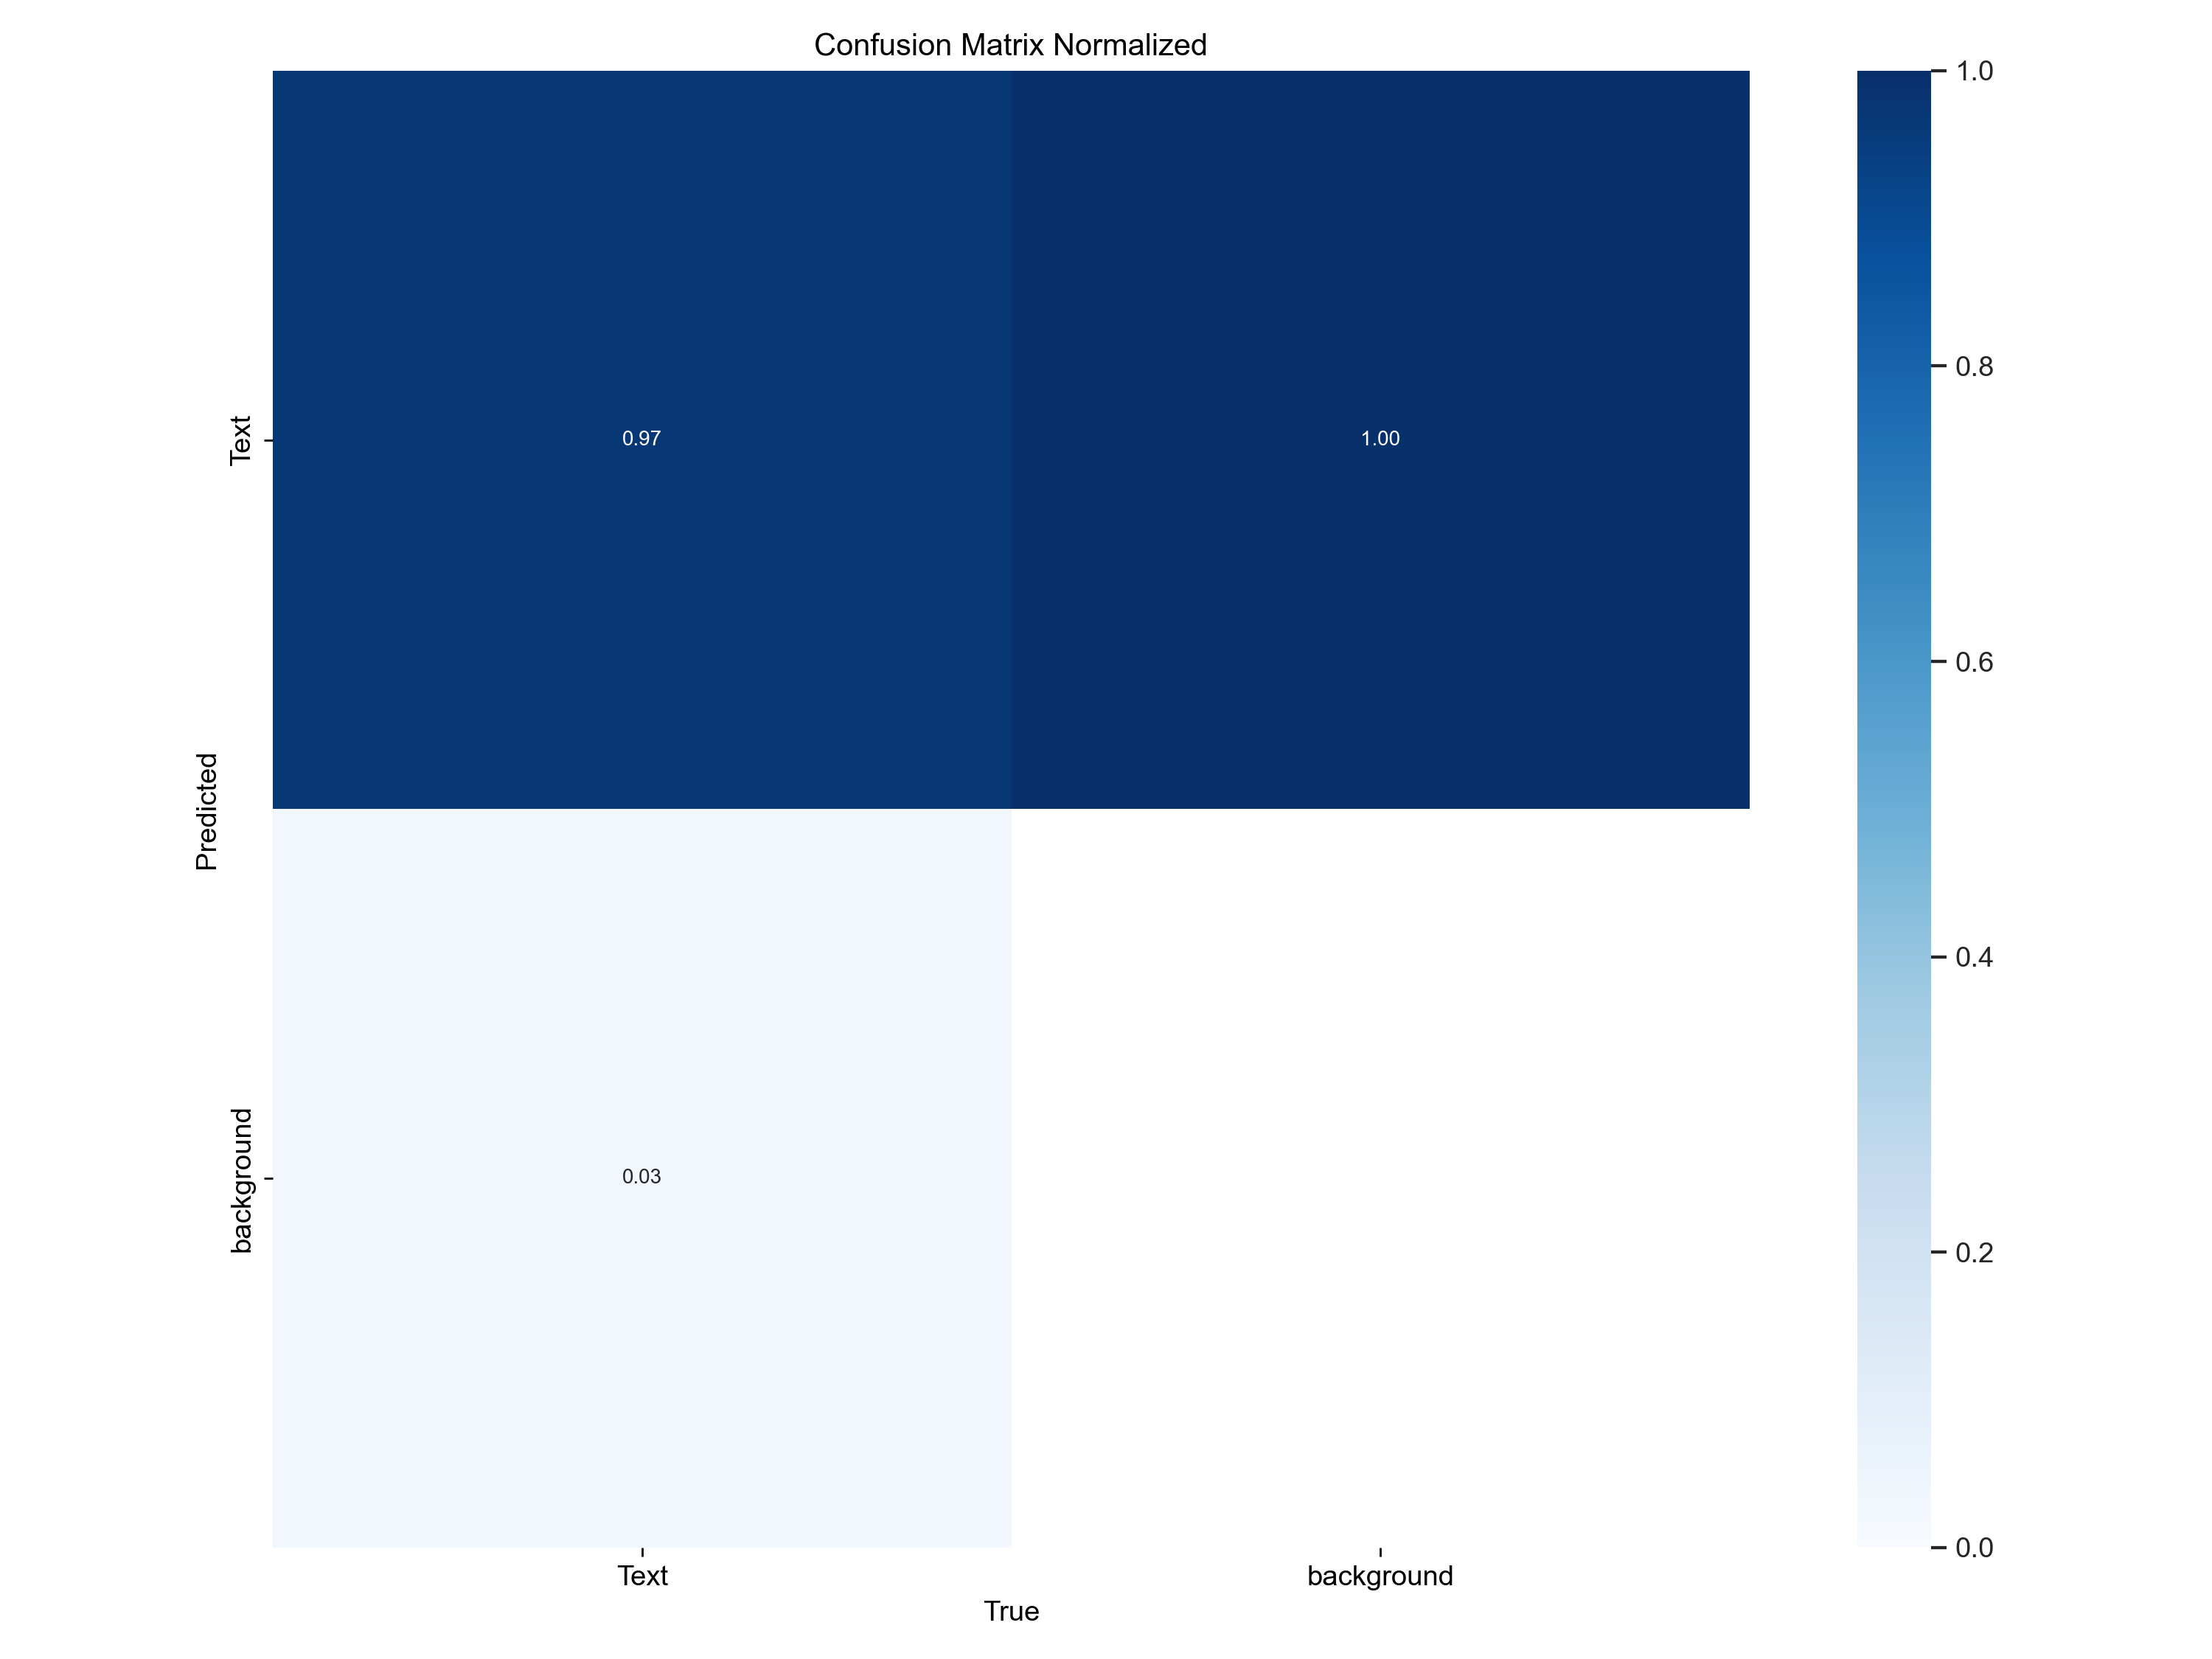

In [ ]:
# show confusion matrix to analyze overall accuracy

# %matplotlib inline
# from PIL import Image

Image.open('/Users/oliviasteed/runs/detect/train3/confusion_matrix_normalized.png')

### Test (Text detection)

Testing model on test set images

In [ ]:
# test model with test data

# model = YOLO("/Users/oliviasteed/runs/detect/train3/weights/best.pt)  # this is the model path

model("/Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/train/images/100_jpg.rf.072e86458094f004ab381eb018f48ea0.jpg", save=True)
# does not work


image 1/1 /Users/oliviasteed/Desktop/iat 360/CV_Data/textdetection/train/images/100_jpg.rf.072e86458094f004ab381eb018f48ea0.jpg: 640x640 1 Text, 405.9ms
Speed: 21.6ms preprocess, 405.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train33


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[ 13,  13,  13],
         [  9,   9,   9],
         [  7,   7,   7],
         ...,
         [ 30,  32,  32],
         [ 23,  23,  23],
         [ 21,  21,  21]],
 
        [[ 14,  14,  14],
         [  9,   9,   9],
         [  7,   7,   7],
         ...,
         [ 30,  32,  32],
         [ 20,  20,  20],
         [ 16,  16,  16]],
 
        [[ 21,  21,  21],
         [ 16,  16,  16],
         [ 12,  12,  12],
         ...,
         [ 28,  30,  30],
         [ 21,  21,  21],
         [ 18,  18,  18]],
 
        ...,
 
        [[ 44,  46,  46],
         [ 49,  51,  51],
         [ 61,  61,  61],
         ...,
         [189, 190, 200],
         [181, 182, 192],
         [159, 160, 170]],
 
        [[ 46,  48,  48],
         [ 45,  47,  47],
         [ 50,  50,  50],
         ...,
         [179, 180, 

In [ ]:
# validate on train data

%matplotlib inline
from PIL import Image

model("/Users/oliviasteed/Desktop/Text Dataset/images/train/Ar_16_An_16_TNR_16_Image14_jpg.rf.0db41e1c1897b2d8cc6e07640ae17911.jpg", save=True)
# detects text!!!!!!


image 1/1 /Users/oliviasteed/Desktop/Text Dataset/images/train/Ar_16_An_16_TNR_16_Image14_jpg.rf.0db41e1c1897b2d8cc6e07640ae17911.jpg: 640x640 3 Texts, 312.7ms
Speed: 10.2ms preprocess, 312.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train35


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[211, 255, 255],
         [210, 244, 244],
         [224, 221, 223],
         ...,
         [220, 220, 220],
         [238, 238, 238],
         [255, 255, 255]],
 
        [[223, 255, 255],
         [219, 237, 238],
         [231, 217, 219],
         ...,
         [216, 216, 216],
         [234, 234, 234],
         [253, 253, 253]],
 
        [[244, 249, 248],
         [238, 227, 229],
         [249, 208, 213],
         ...,
         [211, 211, 211],
         [227, 227, 227],
         [247, 247, 247]],
 
        ...,
 
        [[243, 239, 250],
         [230, 226, 237],
         [220, 216, 227],
         ...,
         [210, 219, 223],
         [221, 230, 234],
         [241, 250, 254]],
 
        [[249, 245, 255],
         [237, 233, 244],
         [223, 219, 230],
         ...,
         [210, 222, 

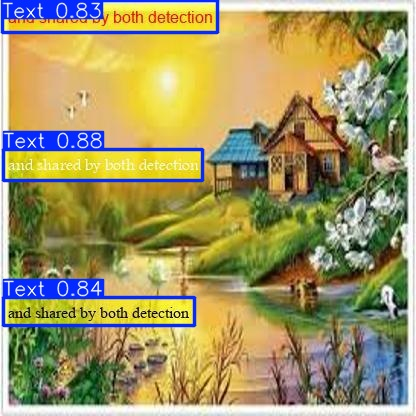

In [ ]:
Image.open('/Users/oliviasteed/runs/detect/train35/Ar_16_An_16_TNR_16_Image14_jpg.rf.0db41e1c1897b2d8cc6e07640ae17911.jpg')

In [ ]:
model("/Users/oliviasteed/Desktop/Text Dataset/images/test/121_jpg.rf.47a836a556ba2bbe6cb8c97f7590e8eb.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/Text Dataset/images/test/121_jpg.rf.47a836a556ba2bbe6cb8c97f7590e8eb.jpg: 640x640 3 Texts, 325.6ms
Speed: 7.1ms preprocess, 325.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train37


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[246, 223, 227],
         [248, 225, 229],
         [252, 227, 231],
         ...,
         [255, 236, 244],
         [255, 236, 244],
         [255, 236, 244]],
 
        [[249, 224, 228],
         [250, 225, 229],
         [251, 226, 230],
         ...,
         [255, 236, 244],
         [255, 236, 244],
         [255, 236, 244]],
 
        [[251, 224, 227],
         [251, 224, 227],
         [252, 225, 228],
         ...,
         [255, 236, 244],
         [255, 236, 244],
         [255, 236, 244]],
 
        ...,
 
        [[231, 162, 135],
         [231, 162, 135],
         [231, 162, 135],
         ...,
         [111,  72,  63],
         [111,  72,  63],
         [111,  72,  63]],
 
        [[230, 161, 134],
         [230, 161, 134],
         [231, 162, 135],
         ...,
         [115,  73, 

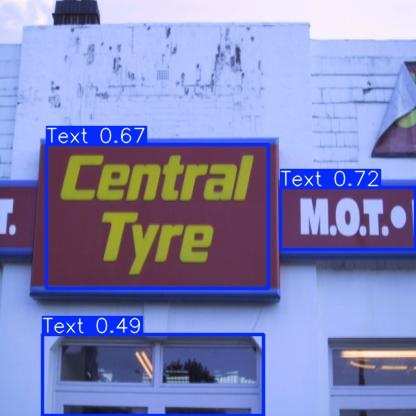

In [ ]:
Image.open('/Users/oliviasteed/runs/detect/train37/121_jpg.rf.47a836a556ba2bbe6cb8c97f7590e8eb.jpg')

In [ ]:
model("/Users/oliviasteed/Desktop/Text Dataset/images/test/66_png.rf.0c3431b7e21b2e8076ce3450db980dd8.jpg", save=)


image 1/1 /Users/oliviasteed/Desktop/Text Dataset/images/test/66_png.rf.0c3431b7e21b2e8076ce3450db980dd8.jpg: 640x640 4 Texts, 366.4ms
Speed: 9.5ms preprocess, 366.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train38


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 

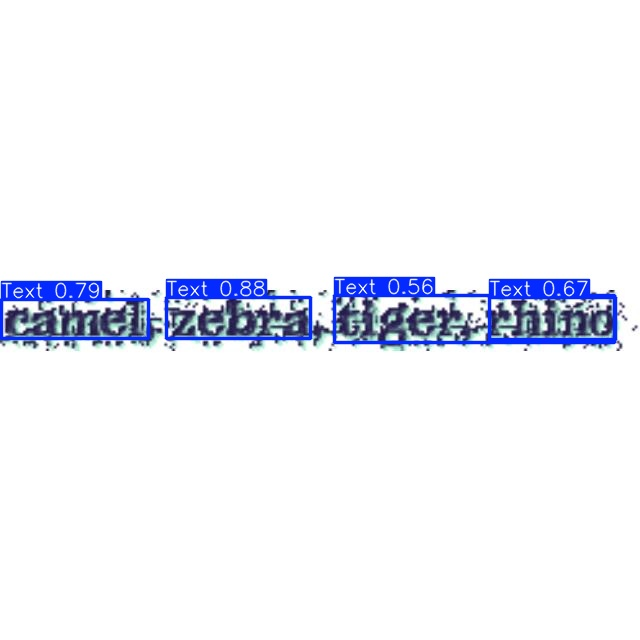

In [ ]:
Image.open('/Users/oliviasteed/runs/detect/train38/66_png.rf.0c3431b7e21b2e8076ce3450db980dd8.jpg')

In [ ]:
model = YOLO("/Users/oliviasteed/runs/detect/train3/weights/best.pt")  # this is the model path

In [ ]:
model("/Users/oliviasteed/Desktop/IMG_9534.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/IMG_9534.jpg: 288x640 1 Text, 152.0ms
Speed: 4.4ms preprocess, 152.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)
Results saved to runs/detect/predict2


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[170, 176, 175],
         [167, 173, 172],
         [164, 170, 169],
         ...,
         [165, 171, 170],
         [164, 170, 169],
         [163, 169, 168]],
 
        [[170, 176, 175],
         [167, 173, 172],
         [164, 170, 169],
         ...,
         [165, 171, 170],
         [164, 170, 169],
         [163, 169, 168]],
 
        [[170, 176, 175],
         [167, 173, 172],
         [164, 170, 169],
         ...,
         [165, 171, 170],
         [164, 170, 169],
         [163, 169, 168]],
 
        ...,
 
        [[155, 161, 160],
         [158, 164, 163],
         [162, 168, 167],
         ...,
         [162, 168, 167],
         [163, 169, 168],
         [164, 170, 169]],
 
        [[152, 158, 157],
         [155, 161, 160],
         [160, 166, 165],
         ...,
         [157, 163, 

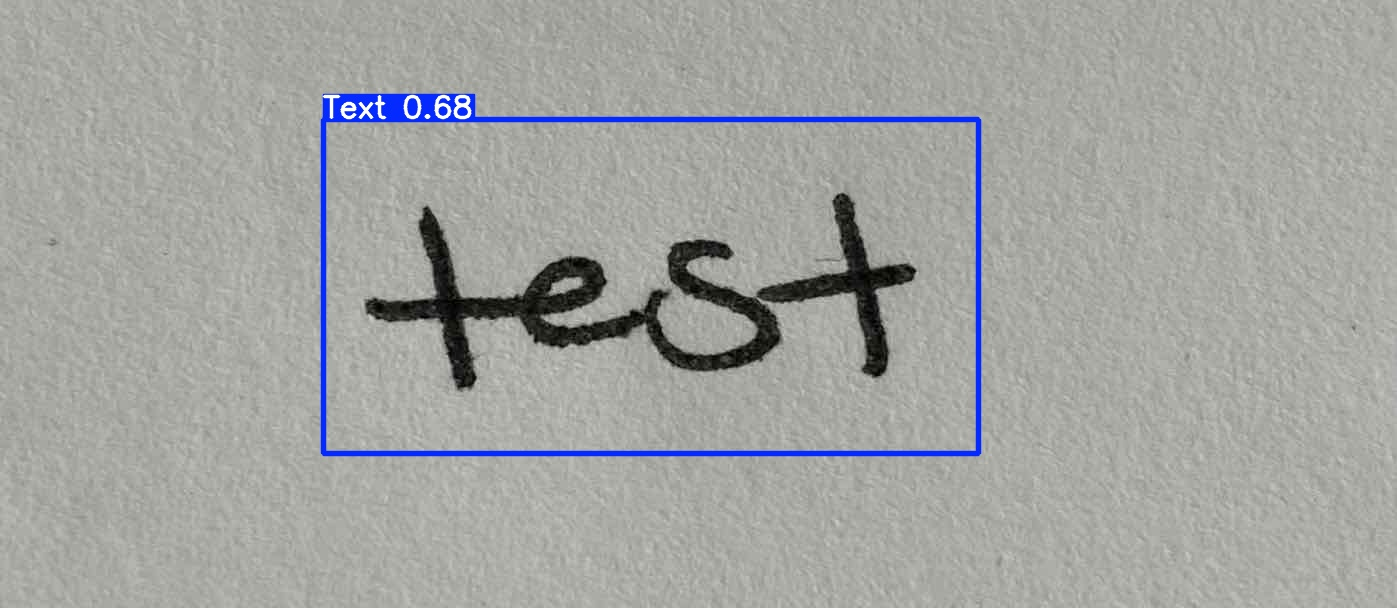

In [ ]:
Image.open('/Users/oliviasteed/runs/detect/predict/IMG_9534.jpg')

## Detect text from image

In [ ]:
results = model("/Users/oliviasteed/Desktop/IMG_9534.jpg")


image 1/1 /Users/oliviasteed/Desktop/IMG_9534.jpg: 288x640 1 Text, 302.6ms
Speed: 20.6ms preprocess, 302.6ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)


In [ ]:
# used these as references for getting bounding box and saving to new image
# https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924#:~:text=In%20Yolo%2C%20the%20bounding%20box,centre%20of%20the%20bounding%20box.
# https://github.com/ultralytics/ultralytics/issues/2143


# make results bounding box into list

for result in results[0].boxes.xyxy:  # Iterate through detected objects
    x_min, y_min, x_max, y_max = result.tolist()

    print(f'Bounding box: ({x_min}, {y_min}, {x_max}, {y_max})')

Bounding box: (323.46038818359375, 119.45033264160156, 978.3939819335938, 453.9836730957031)


In [ ]:
image_name = "IMG_9534"

# load predicted test image
image_path = f'/Users/oliviasteed/runs/detect/predict/{image_name}.jpg'
image = cv2.imread(image_path)

box_width = int(x_max - x_min)
box_height = int(y_max - y_min)

# print(box_width,",",box_height)

cropped_region = image[int(y_min):int(y_max), int(x_min):int(x_max)]
cv2.imwrite(f'/Users/oliviasteed/runs/detect/predict/{image_name}textcrop.jpg', cropped_region)


True

In [ ]:
# predict and save all in one function (trying on this)

def predict_object_detection(image_path, file_name):
  # output_path = file_name + "bbox.jpg"
  # results = model(image_path, save=True, project=output_path)
  results = model(image_path, save=True)
  #how to save with custom name?

#add check in case no detection

  for result in results[0].boxes.xyxy:  # Iterate through detected objects
    x_min, y_min, x_max, y_max = result.tolist()

  # load predicted test image
  # image = cv2.imread(output_path)
  image = cv2.imread("/Users/oliviasteed/runs/detect/predict2/IMG_9534.jpg")

  box_width = int(x_max - x_min)
  box_height = int(y_max - y_min)

  # print(box_width,",",box_height)

  crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]
  cv2.imwrite(image_path + "textcrop.jpg", crop)





In [ ]:
predict_object_detection("/Users/oliviasteed/Desktop/IMG_9534.jpg", "IMG_9534")


image 1/1 /Users/oliviasteed/Desktop/IMG_9534.jpg: 288x640 1 Text, 204.4ms
Speed: 16.0ms preprocess, 204.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)
Results saved to IMG_9534bbox.jpg/predict


# 2. Letters Detection

Identifying the letters in text, and printing it out.

## Data preprocessing

Datasets: two datasets with images/screenshots of text with labeled bounding boxes around each letter.

https://universe.roboflow.com/yolo-3ovhz/letters-xsg2w

https://universe.roboflow.com/arturs-jelagins-a8sef/supercaptcha

In [ ]:
# letter detection dataset: https://universe.roboflow.com/yolo-3ovhz/letters-xsg2w
# capcha dataset: https://universe.roboflow.com/adhdob/new-captcha-k3rsn/dataset/5
# test capcha dataset: https://universe.roboflow.com/testcaptcha/test-captcha-rslyl/dataset/1

# super capcha: https://universe.roboflow.com/arturs-jelagins-a8sef/supercaptcha


# new model for letter detection
lettersModel = YOLO("yolov8n.yaml").load("yolov8n.pt")

# train model with labeled letter data
lettersResults = lettersModel.train(data="/Users/oliviasteed/Desktop/Letters Dataset/Letters/data.yaml", epochs=8, patience=5, batch=8, lr0=0.0005)


Transferred 355/355 items from pretrained weights
New https://pypi.org/project/ultralytics/8.3.24 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/oliviasteed/Desktop/Letters Dataset/Letters/data.yaml, epochs=8, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=yolov8n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False

train: Scanning /Users/oliviasteed/Desktop/Letters Dataset/Letters/train/labels.
val: Scanning /Users/oliviasteed/Desktop/Letters Dataset/Letters/valid/labels.ca

Plotting labels to runs/detect/train5/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000357, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8         0G      3.129      4.573       2.85        139        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8         0G      2.115      4.311      1.872        117        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0496      0.163      0.041     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8         0G      1.715      4.033      1.584        144        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0307       0.55     0.0531     0.0311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8         0G       1.57      3.861      1.494        114        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0301      0.629     0.0562     0.0355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8         0G      1.513      3.738      1.459        124        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0389      0.675     0.0676     0.0422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8         0G      1.455       3.69      1.433        137        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0358      0.723     0.0757       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8         0G      1.484      3.631      1.433        167        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0527      0.784     0.0952       0.06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8         0G      1.421      3.574      1.426        168        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0314      0.799     0.0914     0.0576



8 epochs completed in 0.481 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.3MB

Validating runs/detect/train5/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,010,328 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         57        500     0.0523      0.785      0.095     0.0599
                     .         13         18     0.0323      0.222      0.119     0.0293
                     0         14         19     0.0579      0.789      0.072     0.0478
                     1         13         14     0.0149      0.786     0.0519     0.0363
                     2         16         19     0.0211      0.895     0.0339     0.0212
                     5         23         25      0.037       0.92     0.0612     0.0371
                     6         21         26     0.0641      0.846     0.0779     0.0494
                     8         14         18       0.04      0.889     0.0719     0.0502
                     A         20         24     0.0449          1      0.105     0.0689
                     B         12         15     0.0193          1     0.0598     0.0427
                     C         13         14     0.0142      0.929     0.0549     0.0362
                     

In [ ]:
# model = YOLO("/Users/oliviasteed/runs/detect/train3/weights/best.pt")  # this is the model path

In [ ]:
lettersModel.train(data="/Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha.v8i.yolov8/data.yaml", epochs=8, patience=5, batch=8, lr0=0.0005)

New https://pypi.org/project/ultralytics/8.3.24 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha.v8i.yolov8/data.yaml, epochs=8, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train53, exist_ok=False, pretrained=yolov8n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=Non

train: Scanning /Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha.v8i.yolo
val: Scanning /Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha.v8i.yolov8


Plotting labels to runs/detect/train53/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000204, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train53
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8         0G      2.906      5.058      2.594         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735   0.000125    0.00378   7.13e-05   1.11e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8         0G       2.55      4.947      2.258         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735    0.00244     0.0434    0.00383   0.000805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8         0G      2.287      4.805      2.013         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0123      0.178     0.0182    0.00786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8         0G      2.008      4.693      1.809         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735    0.00823       0.26      0.029     0.0174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8         0G      1.821      4.597      1.683         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735    0.00971      0.333     0.0387     0.0261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8         0G      1.791      4.534       1.67         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735    0.00979      0.384     0.0384     0.0266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8         0G      1.644        4.5      1.567         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0106      0.423     0.0388     0.0273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8         0G      1.582       4.44      1.529         42        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0113       0.45     0.0398     0.0282



8 epochs completed in 0.593 hours.
Optimizer stripped from runs/detect/train53/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train53/weights/best.pt, 6.3MB

Validating runs/detect/train53/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,014,423 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        105        735     0.0114      0.452     0.0401     0.0283
                     A         15         16    0.00826          1     0.0487     0.0343
                     B         15         16     0.0204          1      0.235      0.189
                     C         16         17     0.0188          1     0.0348     0.0219
                     D         16         17     0.0286      0.941     0.0549     0.0451
                     E         18         19     0.0209          1     0.0919     0.0679
                     F         14         14          0          0          0          0
                     G         19         22     0.0125     0.0455    0.00661   0.000661
                     H         19         20    0.00881          1     0.0494     0.0354
                     J         15         18     0.0138      0.667     0.0352     0.0242
                     K         16         16     0.0202          1     0.0865     0.0495
                     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x17bcc3da0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,   

In [ ]:
lettersModel.val()

WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,014,423 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha.v8i.yolov8
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        105        735     0.0114      0.452     0.0401     0.0283
                     A         15         16    0.00826          1     0.0487     0.0343
                     B         15         16     0.0204          1      0.235      0.189
                     C         16         17     0.0188          1     0.0348     0.0219
                     D         16         17     0.0286      0.941     0.0549     0.0451
                     E         18         19     0.0209          1     0.0919     0.0679
                     F         14         14          0          0          0          0
                     G         19         22     0.0125     0.0455    0.00661   0.000661
                     H         19         20    0.00881          1     0.0494     0.0354
                     J         15         18     0.0138      0.667     0.0352     0.0242
                     K         16         16     0.0202          1     0.0865     0.0495
                     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x175348ec0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,   

In [ ]:
lettersModel("/Users/oliviasteed/Desktop/IMG_9534.jpgtextcrop.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/IMG_9534.jpgtextcrop.jpg: 352x640 (no detections), 1045.7ms
Speed: 8.5ms preprocess, 1045.7ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/train534


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '.', 1: '0', 2: '1', 3: '2', 4: '5', 5: '6', 6: '8', 7: 'A', 8: 'B', 9: 'C', 10: 'D', 11: 'E', 12: 'G', 13: 'H', 14: 'I', 15: 'J', 16: 'K', 17: 'L', 18: 'M', 19: 'N', 20: 'O', 21: 'S', 22: 'T', 23: 'U'}
 obb: None
 orig_img: array([[[247,  42,   4],
         [249,  42,   4],
         [255,  43,   4],
         ...,
         [254,  43,   6],
         [253,  41,   1],
         [255,  46,   4]],
 
        [[247,  39,   3],
         [252,  44,   8],
         [255,  48,  12],
         ...,
         [242,  44,   8],
         [250,  47,  10],
         [250,  41,   3]],
 
        [[255,  44,  10],
         [246,  42,   7],
         [226,  33,   0],
         ...,
         [212,  42,  14],
         [229,  40,   9],
         [249,  43,   8]],
 
        ...,
 
        [[255,  44,  13],
         [247,  45,  14],
         [213,  41,  13],
         ...

In [ ]:
lettersModel("/Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha.v8i.yolov8/train/images/acaptchaacaptcha_php__CAPTCHA-t_0_60528700_1694270019_png.rf.ddfd1dceaf24823dd15bd5b40673eda3.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha.v8i.yolov8/train/images/acaptchaacaptcha_php__CAPTCHA-t_0_60528700_1694270019_png.rf.ddfd1dceaf24823dd15bd5b40673eda3.jpg: 640x640 (no detections), 335.4ms
Speed: 13.3ms preprocess, 335.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train535


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '.', 1: '0', 2: '1', 3: '2', 4: '5', 5: '6', 6: '8', 7: 'A', 8: 'B', 9: 'C', 10: 'D', 11: 'E', 12: 'G', 13: 'H', 14: 'I', 15: 'J', 16: 'K', 17: 'L', 18: 'M', 19: 'N', 20: 'O', 21: 'S', 22: 'T', 23: 'U'}
 obb: None
 orig_img: array([[[238, 238, 238],
         [238, 238, 238],
         [238, 238, 238],
         ...,
         [222, 222, 222],
         [222, 222, 222],
         [222, 222, 222]],
 
        [[238, 238, 238],
         [238, 238, 238],
         [238, 238, 238],
         ...,
         [222, 222, 222],
         [222, 222, 222],
         [222, 222, 222]],
 
        [[238, 238, 238],
         [238, 238, 238],
         [238, 238, 238],
         ...,
         [222, 222, 222],
         [222, 222, 222],
         [222, 222, 222]],
 
        ...,
 
        [[221, 221, 221],
         [221, 221, 221],
         [221, 221, 221],
         ...

In [ ]:
lettersModel.train(data="/Users/oliviasteed/Desktop/Letters Dataset/new-captcha.v5i.yolov8/data.yaml", epochs=3, patience=5, batch=8, lr0=0.0005)

New https://pypi.org/project/ultralytics/8.3.24 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/oliviasteed/Desktop/Letters Dataset/new-captcha.v5i.yolov8/data.yaml, epochs=3, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train5363, exist_ok=False, pretrained=yolov8n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=No

train: Scanning /Users/oliviasteed/Desktop/Letters Dataset/new-captcha.v5i.yolov
val: Scanning /Users/oliviasteed/Desktop/Letters Dataset/new-captcha.v5i.yolov8/


Plotting labels to runs/detect/train5363/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000152, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5363
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.675      3.037      1.366         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all          8         44       0.57      0.558       0.61      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      1.661      2.961      1.358         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all          8         44       0.71      0.535      0.642      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.635        2.9       1.34         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all          8         44       0.61      0.606      0.711      0.411



3 epochs completed in 3.043 hours.
Optimizer stripped from runs/detect/train5363/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5363/weights/best.pt, 6.2MB

Validating runs/detect/train5363/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,017,738 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all          8         44      0.609      0.606      0.711      0.411
                     1          1          1       0.62          1      0.995      0.697
                     2          4          5      0.563        0.8      0.895      0.455
                     3          1          1      0.155          1      0.995      0.298
                     6          2          2      0.159        0.5      0.578      0.342
                     7          1          1      0.153          1      0.249      0.149
                     8          3          3      0.601          1      0.913      0.494
                     9          2          2      0.148        0.5      0.595      0.359
                     C          1          1          1          0          0          0
                     D          1          1      0.392          1      0.497      0.348
                     E          1          1      0.377          1      0.995      0.796
                     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 1,  2,  3,  6,  7,  8,  9, 12, 13, 14, 16, 17, 21, 23, 25, 28, 29, 30, 31, 34, 35, 36, 38, 40, 43, 48, 49, 52, 54, 55, 59])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x1692bc8f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.

In [ ]:
lettersModel("/Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha.v8i.yolov8/train/images/acaptchaacaptcha_php__CAPTCHA-t_0_60528700_1694270019_png.rf.ddfd1dceaf24823dd15bd5b40673eda3.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha.v8i.yolov8/train/images/acaptchaacaptcha_php__CAPTCHA-t_0_60528700_1694270019_png.rf.ddfd1dceaf24823dd15bd5b40673eda3.jpg: 640x640 (no detections), 413.3ms
Speed: 6.7ms preprocess, 413.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train53632


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '.', 1: '0', 2: '1', 3: '2', 4: '5', 5: '6', 6: '8', 7: 'A', 8: 'B', 9: 'C', 10: 'D', 11: 'E', 12: 'G', 13: 'H', 14: 'I', 15: 'J', 16: 'K', 17: 'L', 18: 'M', 19: 'N', 20: 'O', 21: 'S', 22: 'T', 23: 'U'}
 obb: None
 orig_img: array([[[238, 238, 238],
         [238, 238, 238],
         [238, 238, 238],
         ...,
         [222, 222, 222],
         [222, 222, 222],
         [222, 222, 222]],
 
        [[238, 238, 238],
         [238, 238, 238],
         [238, 238, 238],
         ...,
         [222, 222, 222],
         [222, 222, 222],
         [222, 222, 222]],
 
        [[238, 238, 238],
         [238, 238, 238],
         [238, 238, 238],
         ...,
         [222, 222, 222],
         [222, 222, 222],
         [222, 222, 222]],
 
        ...,
 
        [[221, 221, 221],
         [221, 221, 221],
         [221, 221, 221],
         ...